# Importing Required Packages

In [1]:
# Load Packages
# Basic packages/visualization
import os
import pandas as pd
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import gc
import random

# Deep Learning Packages
from torch.utils.data import DataLoader
import torch.optim as optim

# Custom written .py files
from helper import ground_truth_background, back_images
from clubfoot_transforms import *
from pytorchclubfootdataset import *
from models import FCNmodel_3pool, FCNmodel_2pool
from helper import show_image_batch_model, show_single_image_model, save_image_batch_model, return_criterions
from loss_functions import *
from training import *

# Data Visualization and Training/Validation Splits

__ground_truth_files(clubfoot_type, base_dir)__ <br>
__Inputs:__ 
- __clubfoot_type__- 'AP', 'LAT', or None - this indicates the type of radiographs you are loading for training. None loads all images <br>
- __base_dir__ - the directory with all of the input data with the labeled folders for Clubfoot and Non-clubfoot images <br>


__Output:__ 
- A dataframe with the paths for the images, labeled bones, and background segmentation masks<br>
- Note: If any of the images are missing either the labeled bone or background segmentation mask they will be printed in the output

In [2]:
# from helper import ground_truth_background, back_images
print(os.getcwd())
base = 'C:\\Users\\danie\\OneDrive\\Documents\\Clubfoot\\GroundTruthSegmentation\\Final_Seg_Maps_NIFTI2'
data = ground_truth_background(base, None) # clubfoot_type = 'AP','LAT', None
print('Total # of radiographs inlcuded in this study: ', len(data))

C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Code
Total # of radiographs inlcuded in this study:  461


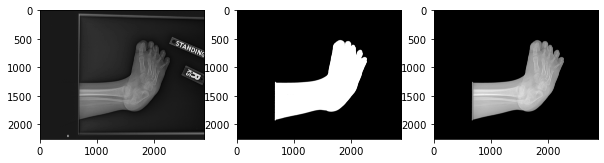

In [3]:
# Example input image, background mask, and mask overlay on input image
back_images(data, 24)

In [4]:
# Splitting the data into the predetermined training and validation sets
split = pd.read_csv('Clubfoot_Update_012521.csv')

split['Folder ID'] = split['Folder ID'].astype(str)
data_2 = data.merge(split, left_on='folder', right_on='Folder ID', how='inner')
data_2 = data_2.drop(columns = ['Folder ID'])

training_data = data_2[data_2['Split'] == 'Training']
validation_data = data_2[data_2['Split'] == 'Validation']

# Clubfoot_Update_012521
print(' The training data size is: ', len(training_data),'\n',
      'The validation data size is: ', len(validation_data), '\n')

del data, data_2, split
gc.collect()
gc.collect();

 The training data size is:  274 
 The validation data size is:  50 



## Loading and Visualizing Training Data

In [5]:
transformations = [toTensorMask(),
                   Resize_Imgs([272, 256]),
                   Normalize(), 
                   RandomRotate(0.5),
                   RandomFlip(0.5)] 

training_dataset = BoneBackground(df = training_data,
                                    transform=transforms.Compose(transformations)
                                  )
training_dataloader = DataLoader(training_dataset, batch_size=8,
                        shuffle=True, num_workers=0)

0 torch.Size([8, 1, 272, 256]) torch.Size([8, 1, 272, 256])


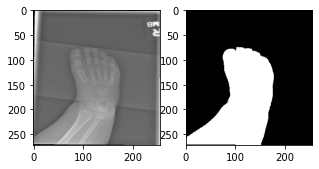

In [6]:
# Helper function to show a batch
# Mover to Helper.py
from helper import show_single_image, show_image_batch
        
for i_batch, sample_batched in enumerate(training_dataloader):
    print(i_batch, sample_batched['image'].size(),sample_batched['mask'].size())    
    if i_batch == 0:
        show_single_image(sample_batched)
        break

#  Load the Deep Learning Model

In [7]:
# loaded from models.py
model = FCNmodel_2pool(n_class=1)
# move model to cuda/gpu device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
#summary(model, input_size=(1, 272, 256), device = device.type) # device.type) 
# Trainable params: 6,041,188

# Basic Visualization of the Input Data 

0 torch.Size([8, 1, 272, 256]) torch.Size([8, 1, 272, 256])


<Figure size 432x288 with 0 Axes>

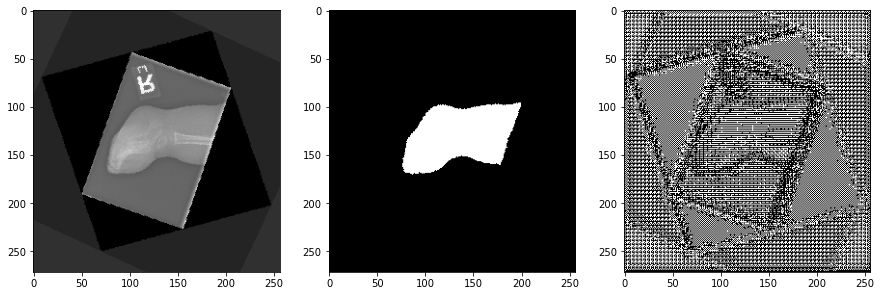

In [8]:
for i_batch, sample_batched in enumerate(training_dataloader):
    print(i_batch, sample_batched['image'].size(),sample_batched['mask'].size())
    if i_batch == 0:
        mask = model(sample_batched['image'].to(device))
        plt.figure()
        show_single_image_model(sample_batched, torch.round(mask))
        break

In [9]:
# Simple function to calculate the dice coeffificent by an individual image in batch
def dice_by_image(sample_batched, output, data, i_batch):
    for j in range(sample_batched['mask'].shape[0]):
        gt = sample_batched['mask'][j,]
        model_mask = output[j,]
        
        for i in range(sample_batched['mask'].shape[1]):
            gt_bone = gt[i,]
            model_mask_bone = model_mask[i,]
            data.append([dice_coef(model_mask_bone, gt_bone).item(), i_batch, j])
         
    return data

In [ ]:
# Random Grid Search
epochs = 100
base_dir = 'C:\\Users\\danie\\OneDrive\\Documents\\Clubfoot\\GroundTruthSegmentation\\Final_Seg_Maps_NIFTI2\\Models'

i = 0
while i < 10:
    i += 1
    # Hyperparamters being tuned
    batch_group = [4, 8, 12, 16]
    lr_group = [1e-2, 0.005, 1e-3]
    criteria_group = [DC_loss2(), BCELoss(), 'Combined']
    augmentations_group = ['Clahe_Aug', 'Aug', 'No_Aug']
    model_num_group = [2, 3]
    
    # Random Selection
    batch = random.choice(batch_group)
    lr = random.choice(lr_group)
    criterionn = random.choice(criteria_group)
    augments = random.choice(augmentations_group)
    model_num = random.choice(model_num_group)
    
    # Defining parameters based upon criterion
    criterion, criterion2, transformations, model = return_criterions(criterionn, augments, model_num) 
        
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)

    logpath = 'batch'+ str(batch) + '_lr' + str(lr) + '_augs' + str(augments) + '_model' + str(model_num) +'_Criterions' + str(criterionn) #str(criterion)[:-3] + '_' + str(criterion2)[:-2]        
    print(batch, lr, criterionn, augments, model_num, '\n')
    print(logpath)

    #################################################################################
    # Training Loop
    #################################################################################
    # Load the data
    validation_dataset = BoneBackground(df = validation_data,
                                         transform=transforms.Compose(transformations)
                                       )
    validation_dataloader = DataLoader(validation_dataset, batch_size = batch,
                            shuffle=False, num_workers=0)

    training_dataset = BoneBackground(df = training_data,
                                        transform=transforms.Compose(transformations)
                                      )
    training_dataloader = DataLoader(training_dataset, batch_size = batch,
                            shuffle=True, num_workers=0)

    # Creating a dictionary of paramters to simplify visualization
    params={
     "num_epochs": epochs, 
        "optimizer": optimizer,
     "criterion": criterion,
     "criterion2": criterion2,
     "train_dl": training_dataloader,
     "val_dl": validation_dataloader,
     "lr_scheduler": scheduler,
        "log_path": logpath,
    "base_dir": base_dir}

    # Training the model
    train_epoch_metrics, val_epoch_metrics = model_training(model, params)

    # Save loss function training and validation plots
    save_images(train_epoch_metrics, train_epoch_metrics, base_dir, logpath)

    # Reloading the Model with the Best Parameters
    if model_num == 2:
        model = FCNmodel_2pool(n_class=1)
    else:
        model = FCNmodel_3pool(n_class=1)

    optimizer_ = optim.Adam(model.parameters())
    checkpoint = torch.load(os.path.join(base_dir, logpath + '.best.pth.tar'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer_.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to('cpu')

    # Saving example images of the model output
    for i_batch, sample_batched in enumerate(validation_dataloader):
        print(i_batch, sample_batched['image'].size(),sample_batched['mask'].size())
        if i_batch == 0:
            mask = model(sample_batched['image'].to('cpu'))
            plt.figure()
            save_image_batch_model(sample_batched, torch.round(mask), base_dir, logpath)
            break      


    # Create the pandas DataFrame of Dice coefficients on a slice by slice basis for validation data
    mask_name = ['background', 'batch_num', 'j']
    data = []

    for i_batch, sample_batched in enumerate(validation_dataloader):
        mask = model(sample_batched['image'])
        data = dice_by_image(sample_batched, torch.round(mask), data, i_batch)

    dice_df = pd.DataFrame(data, columns = ['dice', 'batch', 'batch_num']) 
    dice_df.to_csv(logpath + '.csv')

12 0.005 BCELoss() Aug 2 

batch12_lr0.005_augsAug_model2_CriterionsBCELoss()
finished epoch 0 train mode loss 0.389459746039432
finished epoch 0 test mode loss 0.30989766120910645
The best loss value at epoch 0 is:  0.30989766120910645
finished epoch 1 train mode loss 0.2742166642261588
finished epoch 1 test mode loss 0.2624959975481033
The best loss value at epoch 1 is:  0.2624959975481033
finished epoch 2 train mode loss 0.2704084573880486
finished epoch 2 test mode loss 0.29587424397468565
finished epoch 3 train mode loss 0.23920015925946442
finished epoch 3 test mode loss 0.24727721512317657
The best loss value at epoch 3 is:  0.24727721512317657
finished epoch 4 train mode loss 0.24311359161915985
finished epoch 4 test mode loss 0.258317568898201
finished epoch 5 train mode loss 0.22367998892846314
finished epoch 5 test mode loss 0.26589391231536863
finished epoch 6 train mode loss 0.23222172713798026
finished epoch 6 test mode loss 0.2018871396780014
The best loss value at epoch